# 20. Optuna自動ハイパーパラメータ最適化 (Optuna Hyperparameter Optimization)

## 概要
Optunaを使った効率的なハイパーパラメータ最適化の手法を学びます。

## 学習目標
- Optunaの基本的な使い方を理解できる
- ベイズ最適化の原理を理解できる
- GridSearch/RandomSearchとの違いを理解できる
- Pruning（枝刈り）で効率を上げられる
- 並列最適化を実行できる
- 最適化結果を可視化・分析できる

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer, load_iris
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
import optuna
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)
import warnings
warnings.filterwarnings('ignore')

# 設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

## 1. Optunaとは

### ハイパーパラメータ最適化の課題

従来の手法の問題点：
- **GridSearch**: 探索空間が広いと計算コストが膨大
- **RandomSearch**: 効率が悪く、最適解に到達しにくい

### Optunaの特徴

1. **ベイズ最適化**
   - 過去の試行結果を学習
   - 有望な領域を効率的に探索

2. **Pruning（枝刈り）**
   - 見込みのない試行を早期終了
   - 計算時間を大幅削減

3. **並列最適化**
   - 複数プロセスで同時実行
   - スケーラビリティが高い

4. **フレームワーク非依存**
   - scikit-learn、PyTorch、TensorFlowなど対応
   - 柔軟な統合

## 2. 基本的な使い方

### Optunaの基本構造

```python
def objective(trial):
    # パラメータの提案
    param = trial.suggest_float('param', 0.0, 1.0)
    
    # モデルの学習と評価
    score = train_and_evaluate(param)
    
    # 最大化したいスコアを返す
    return score

# 最適化の実行
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)
```

In [2]:
# データの準備
cancer = load_breast_cancer()
X, y = cancer.data, cancer.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"訓練データ: {X_train.shape}")
print(f"テストデータ: {X_test.shape}")

訓練データ: (455, 30)
テストデータ: (114, 30)


In [3]:
# 基本的なOptuna最適化の例
def objective_rf(trial):
    """
    RandomForestのハイパーパラメータを最適化する目的関数
    """
    # パラメータの提案
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'random_state': 42
    }
    
    # モデルの学習と評価
    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    
    return score

# Studyの作成と最適化
study_rf = optuna.create_study(direction='maximize', study_name='rf_optimization')
study_rf.optimize(objective_rf, n_trials=50, show_progress_bar=True)

print("\n最適化完了！")
print(f"最良スコア: {study_rf.best_value:.4f}")
print(f"\n最良パラメータ:")
for key, value in study_rf.best_params.items():
    print(f"  {key}: {value}")

  0%|          | 0/50 [00:00<?, ?it/s]


最適化完了！
最良スコア: 0.9560

最良パラメータ:
  n_estimators: 62
  max_depth: 17
  min_samples_split: 14
  min_samples_leaf: 6
  max_features: log2


In [4]:
# 最適モデルでテストデータを評価
best_model = RandomForestClassifier(**study_rf.best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"テスト精度: {test_accuracy:.4f}")
print("\n分類レポート:")
print(classification_report(y_test, y_pred, target_names=cancer.target_names))

テスト精度: 0.9298

分類レポート:
              precision    recall  f1-score   support

   malignant       0.89      0.93      0.91        42
      benign       0.96      0.93      0.94        72

    accuracy                           0.93       114
   macro avg       0.92      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



## 3. 最適化の可視化

### Optunaの可視化機能

最適化の過程を理解するための可視化ツールが豊富に用意されています。

In [5]:
# 最適化履歴の可視化
fig = plot_optimization_history(study_rf)
fig.update_layout(title='Optimization History', width=900, height=500)
fig.show()

print("このグラフから分かること:")
print("- 試行回数とともにスコアが改善されている")
print("- 最良スコアの更新頻度")
print("- 探索の収束状況")

このグラフから分かること:
- 試行回数とともにスコアが改善されている
- 最良スコアの更新頻度
- 探索の収束状況


In [6]:
# パラメータの重要度
fig = plot_param_importances(study_rf)
fig.update_layout(title='Parameter Importances', width=900, height=500)
fig.show()

print("\nパラメータ重要度の解釈:")
print("- 重要度が高いパラメータ: チューニングの優先度が高い")
print("- 重要度が低いパラメータ: デフォルト値でも十分かもしれない")


パラメータ重要度の解釈:
- 重要度が高いパラメータ: チューニングの優先度が高い
- 重要度が低いパラメータ: デフォルト値でも十分かもしれない


In [7]:
# 並行座標プロット
fig = plot_parallel_coordinate(study_rf)
fig.update_layout(title='Parallel Coordinate Plot', width=900, height=500)
fig.show()

print("\n並行座標プロットの読み方:")
print("- 各線が1回の試行を表す")
print("- 色が濃いほどスコアが高い")
print("- パラメータ間の関係性が見える")


並行座標プロットの読み方:
- 各線が1回の試行を表す
- 色が濃いほどスコアが高い
- パラメータ間の関係性が見える


## 4. GridSearch vs RandomSearch vs Optuna

### 3つの手法を比較

同じ問題に対して、3つの手法で最適化を行い、効率を比較します。

In [8]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
import time

# パラメータ空間の定義
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': list(range(3, 21)),
    'min_samples_split': list(range(2, 21)),
    'min_samples_leaf': list(range(1, 11)),
    'max_features': ['sqrt', 'log2']
}

param_dist = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['sqrt', 'log2']
}

results = {}

# GridSearch (限定的なグリッド)
print("GridSearchCV実行中...")
param_grid_limited = {
    'n_estimators': [50, 150, 250],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5],
    'max_features': ['sqrt']
}
start = time.time()
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_limited, cv=3, n_jobs=-1)
grid.fit(X_train, y_train)
results['GridSearch'] = {
    'time': time.time() - start,
    'score': grid.best_score_,
    'n_trials': len(grid.cv_results_['params'])
}

# RandomizedSearch
print("RandomizedSearchCV実行中...")
start = time.time()
random = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_dist, 
                            n_iter=50, cv=3, random_state=42, n_jobs=-1)
random.fit(X_train, y_train)
results['RandomSearch'] = {
    'time': time.time() - start,
    'score': random.best_score_,
    'n_trials': 50
}

# Optuna (すでに実行済み)
results['Optuna'] = {
    'time': sum(trial.duration.total_seconds() for trial in study_rf.trials),
    'score': study_rf.best_value,
    'n_trials': len(study_rf.trials)
}

# 結果の比較
comparison_df = pd.DataFrame(results).T
print("\n比較結果:")
print(comparison_df)

GridSearchCV実行中...


RandomizedSearchCV実行中...



比較結果:
                   time     score  n_trials
GridSearch     7.546839  0.958246      36.0
RandomSearch   2.434956  0.960439      50.0
Optuna        71.658416  0.956044      50.0


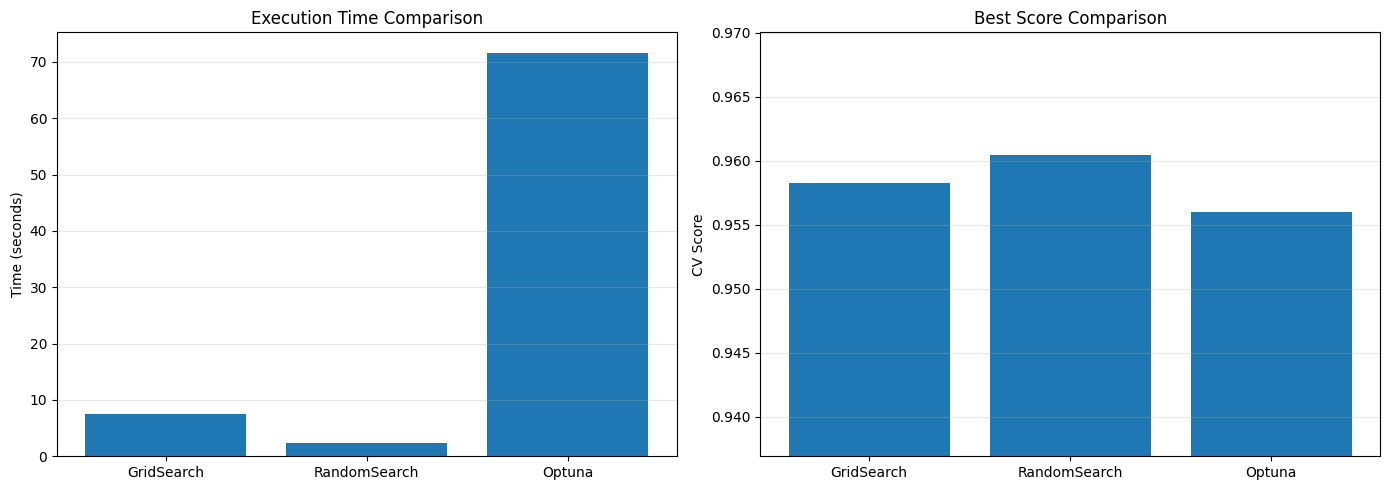


結論:
Optunaは50.0試行で最良スコア0.9560を達成
効率性: 0.013342 (score/second)


In [9]:
# 可視化
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 実行時間の比較
axes[0].bar(comparison_df.index, comparison_df['time'])
axes[0].set_ylabel('Time (seconds)')
axes[0].set_title('Execution Time Comparison')
axes[0].grid(True, alpha=0.3, axis='y')

# スコアの比較
axes[1].bar(comparison_df.index, comparison_df['score'])
axes[1].set_ylabel('CV Score')
axes[1].set_title('Best Score Comparison')
axes[1].set_ylim(comparison_df['score'].min() * 0.98, comparison_df['score'].max() * 1.01)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n結論:")
print(f"Optunaは{comparison_df.loc['Optuna', 'n_trials']}試行で最良スコア{comparison_df.loc['Optuna', 'score']:.4f}を達成")
print(f"効率性: {comparison_df.loc['Optuna', 'score'] / comparison_df.loc['Optuna', 'time']:.6f} (score/second)")

## 5. Pruning（枝刈り）

### Pruningとは

学習の途中で、見込みのない試行を早期終了する機能です。

**利点:**
- 計算時間の大幅削減
- より多くのパラメータを試せる
- リソースの効率的利用

In [10]:
from optuna.integration import OptunaSearchCV
from optuna.pruners import MedianPruner

def objective_with_pruning(trial):
    """
    Pruning機能付きの目的関数
    """
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'random_state': 42
    }
    
    model = RandomForestClassifier(**params)
    
    # 各フォールドでPruningを検討
    scores = []
    for i, (train_idx, val_idx) in enumerate([(slice(0, 300), slice(300, 400)),
                                                (slice(100, 400), slice(0, 100))]):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]
        
        model.fit(X_t, y_t)
        score = model.score(X_v, y_v)
        scores.append(score)
        
        # 中間報告とPruning判定
        trial.report(score, i)
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    return np.mean(scores)

# Pruner付きStudy
study_pruned = optuna.create_study(
    direction='maximize',
    pruner=MedianPruner(n_startup_trials=10, n_warmup_steps=5)
)

study_pruned.optimize(objective_with_pruning, n_trials=50, show_progress_bar=True)

print(f"\n最良スコア: {study_pruned.best_value:.4f}")
print(f"完了した試行: {len([t for t in study_pruned.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
print(f"Pruneされた試行: {len([t for t in study_pruned.trials if t.state == optuna.trial.TrialState.PRUNED])}")

  0%|          | 0/50 [00:00<?, ?it/s]


最良スコア: 0.9600
完了した試行: 50
Pruneされた試行: 0


## 6. 複数モデルの同時最適化

### モデル選択も最適化

どのモデルが最適かも自動で選択できます。

In [11]:
def objective_multi_model(trial):
    """
    複数のモデルから最適なものを選択
    """
    # モデルの選択
    model_name = trial.suggest_categorical('model', ['RandomForest', 'GradientBoosting', 'MLP'])
    
    if model_name == 'RandomForest':
        params = {
            'n_estimators': trial.suggest_int('rf_n_estimators', 50, 200),
            'max_depth': trial.suggest_int('rf_max_depth', 3, 15),
            'min_samples_split': trial.suggest_int('rf_min_samples_split', 2, 10),
            'random_state': 42
        }
        model = RandomForestClassifier(**params)
    
    elif model_name == 'GradientBoosting':
        params = {
            'n_estimators': trial.suggest_int('gb_n_estimators', 50, 200),
            'learning_rate': trial.suggest_float('gb_learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('gb_max_depth', 3, 10),
            'random_state': 42
        }
        model = GradientBoostingClassifier(**params)
    
    else:  # MLP
        params = {
            'hidden_layer_sizes': trial.suggest_categorical('mlp_hidden', [(50,), (100,), (100, 50)]),
            'alpha': trial.suggest_float('mlp_alpha', 1e-5, 1e-1, log=True),
            'learning_rate_init': trial.suggest_float('mlp_lr', 1e-4, 1e-1, log=True),
            'max_iter': 500,
            'random_state': 42
        }
        model = MLPClassifier(**params)
    
    # 評価
    score = cross_val_score(model, X_train, y_train, cv=3, scoring='accuracy').mean()
    return score

# 最適化
study_multi = optuna.create_study(direction='maximize')
study_multi.optimize(objective_multi_model, n_trials=100, show_progress_bar=True)

print(f"\n最良モデル: {study_multi.best_params['model']}")
print(f"最良スコア: {study_multi.best_value:.4f}")
print(f"\n最良パラメータ:")
for key, value in study_multi.best_params.items():
    print(f"  {key}: {value}")

  0%|          | 0/100 [00:00<?, ?it/s]


最良モデル: RandomForest
最良スコア: 0.9604

最良パラメータ:
  model: RandomForest
  rf_n_estimators: 109
  rf_max_depth: 7
  rf_min_samples_split: 6


## 7. まとめ

### 本ノートブックで学んだこと

1. **Optunaの基礎**
   - 目的関数の定義
   - Studyの作成と最適化
   - パラメータの提案方法

2. **可視化**
   - 最適化履歴
   - パラメータ重要度
   - 並行座標プロット

3. **比較**
   - GridSearch vs RandomSearch vs Optuna
   - 効率性と精度のトレードオフ

4. **Pruning**
   - 早期終了による効率化
   - MedianPrunerの使用

5. **複数モデル最適化**
   - モデル選択も含めた最適化
   - 条件分岐の実装

### Optunaを使うべきとき

- ✅ 探索空間が広い
- ✅ 計算コストを抑えたい
- ✅ 最先端の性能が必要
- ✅ 複数のモデルを比較したい

### 次のステップ

- Notebook 21でSHAPによるモデル解釈を学ぶ
- 実際のKaggleコンペでOptunaを活用
- より高度な最適化戦略を探求